In [54]:
## This is to create the the rap maps

## Import the modules
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pygrib
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from metpy.units import units
import cfgrib
import cartopy
import scipy

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
from matplotlib.patches import Rectangle


In [55]:
## Start with the vorticity

## First we need to open our files
## Gulf
p = 'rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
datag = xr.open_mfdataset(p, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 500.0}},
                         combine = 'nested', concat_dim = 'valid_time')

## Now our land files
p2 = 'rap_130*.grb2'


## WE want to open our data. This is for the 500 geopotential height level
datal = xr.open_mfdataset(p2, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 500.0}},
                         combine = 'nested', concat_dim = 'valid_time')

## Now our DWL Files
p4 = 'rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
data_dwl = xr.open_mfdataset(p4, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 500.0}},
                         combine = 'nested', concat_dim = 'valid_time')

## And our DWG Files
p5 = 'rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
data_dwg = xr.open_mfdataset(p5, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 500.0}},
                         combine = 'nested', concat_dim = 'valid_time')

In [56]:
## We need to get our proper slices for this for each regime
## Gulf
datag.sel(x=slice(100,200), y=slice(100,200))
gulf = datag.sel(x=slice(235,262), y=slice(68,90))

##Left x is correct, others need to be adjusted 

## Land
datal.sel(x=slice(100,200), y=slice(100,200))
land = datal.sel(x=slice(235,262), y=slice(68,90))

## DWL
data_dwl.sel(x=slice(100,200), y=slice(100,200))
dwl = data_dwl.sel(x=slice(235,262), y=slice(68,90))

## DWG
data_dwg.sel(x=slice(100,200), y=slice(100,200))
dwg = data_dwg.sel(x=slice(235,262), y=slice(68,90))


## We won't do this for all regimes, but just making sure
## Here is the extent we are trying to match: small_extent = [-93, -96.5 ,28, 30.5]
## Actual extent we end up using [-92.44, -96.56, 27.6, 31,7]
#gulf.latitude.values
print(gulf.longitude.values.min()-360)
print(gulf.longitude.values.max()-360)
print(gulf.latitude.values.min())
print(gulf.latitude.values.max())


-96.54910408370012
-92.88975868938843
27.97189165505204
30.53639158518406


In [86]:
## Now we need to calculate our vorticity 
import scipy.ndimage as ndimage
## GULF
ug = gulf.u.metpy.quantify().metpy.convert_units('m/s')
vg = gulf.v.metpy.quantify().metpy.convert_units('m/s')
wg = gulf.w.metpy.quantify()
lonsg, latsg = gulf.longitude.values, gulf.latitude.values
dxg, dyg = mpcalc.lat_lon_grid_deltas(lonsg, latsg)
dxg = dxg[np.newaxis,:,:]
dyg = dyg[np.newaxis,:,:]
#vor_500g = mpcalc.vorticity(ug, vg, dx=dxg[np.newaxis,:,:], dy=dyg[np.newaxis,:,:]).metpy.convert_units('1/s').data.magnitude
vor_500g = mpcalc.vorticity(ug, vg, dx=dxg, dy=dyg).metpy.convert_units('1/s').data.magnitude
#vor_500g[vor_500g < 1e-5] = np.nan
#avor = ndimage.gaussian_filter(vor_500g, sigma = 1, order = 0) * units('1/s')
vort_adv_g = mpcalc.advection(vor_500g * units('1/s'), u = ug, v = vg, dx=dxg, dy=dyg)

## LAND
ul = land.u.metpy.quantify().metpy.convert_units('m/s')
vl = land.v.metpy.quantify().metpy.convert_units('m/s')
wl = land.w.metpy.quantify()
lonsl, latsl = land.longitude.values, land.latitude.values
dxl, dyl = mpcalc.lat_lon_grid_deltas(lonsl, latsl)
dxl = dxl[np.newaxis,:,:]
dyl = dyl[np.newaxis,:,:]
vor_500l = mpcalc.vorticity(ul, vl, dx=dxl, dy=dyl).metpy.convert_units('1/s').data.magnitude
#vor_500l[vor_500l < 1e-5] = np.nan
vort_adv_l = mpcalc.advection(vor_500l* units('1/s'), u = ul, v = vl, dx=dxl, dy=dyl)

## DWL
u_dwl = dwl.u.metpy.quantify().metpy.convert_units('m/s')
v_dwl = dwl.v.metpy.quantify().metpy.convert_units('m/s')
w_dwl = dwl.w.metpy.quantify()
lons_dwl, lats_dwl = dwl.longitude.values, dwl.latitude.values
dx_dwl, dy_dwl = mpcalc.lat_lon_grid_deltas(lons_dwl, lats_dwl)
dx_dwl = dx_dwl[np.newaxis,:,:]
dy_dwl = dy_dwl[np.newaxis,:,:]
vor_500_dwl = mpcalc.vorticity(u_dwl, v_dwl, dx=dx_dwl, dy=dy_dwl).metpy.convert_units('1/s').data.magnitude
#vor_500_dwl[vor_500_dwl < 1e-5] = np.nan
vort_adv_dwl = mpcalc.advection(vor_500_dwl* units('1/s'), u = u_dwl, v = v_dwl, dx=dx_dwl, dy=dy_dwl)

##DWG
u_dwg = dwg.u.metpy.quantify().metpy.convert_units('m/s')
v_dwg = dwg.v.metpy.quantify().metpy.convert_units('m/s')
w_dwg = dwg.w.metpy.quantify()
lons_dwg, lats_dwg = dwg.longitude.values, dwg.latitude.values
dx_dwg, dy_dwg = mpcalc.lat_lon_grid_deltas(lons_dwg, lats_dwg)
dx_dwg = dx_dwg[np.newaxis,:,:]
dy_dwg = dy_dwg[np.newaxis,:,:]
vor_500_dwg = mpcalc.vorticity(u_dwg, v_dwg, dx=dx_dwg, dy=dy_dwg).metpy.convert_units('1/s').data.magnitude
#vor_500_dwg[vor_500_dwg < 1e-5] = np.nan
vort_adv_dwg = mpcalc.advection(vor_500_dwg* units('1/s'), u = u_dwg, v = v_dwg, dx=dx_dwg, dy=dy_dwg)

/var/folders/pc/3868n6_s5wggqvvzx3s5l2p80000gq/T/ipykernel_78086/3584042135.py:15: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  vort_adv_g = mpcalc.advection(vor_500g * units('1/s'), u = ug, v = vg, dx=dxg, dy=dyg)
/var/folders/pc/3868n6_s5wggqvvzx3s5l2p80000gq/T/ipykernel_78086/3584042135.py:27: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  vort_adv_l = mpcalc.advection(vor_500l* units('1/s'), u = ul, v = vl, dx=dxl, dy=dyl)
/var/folders/pc/3868n6_s5wggqvvzx3s5l2p80000gq/T/ipykernel_78086/3584042135.py:39: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  vort_adv_dwl = mpcalc.advection(vor_500_dwl* units('1/s'), u = u_dwl, v = v_dwl, dx=dx_dwl, dy=dy_dwl)
/var/folders/pc/3868n6_s5wggqvvzx3s5l2p80000gq/T/ipykernel_78086/3584042135.py:51: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  vort_adv_dwg = mpcalc.advection(vor_500_

In [68]:
vort_adv_g.units

<Unit('1 / second ** 2')>

In [87]:
## Save as another variable
## GULF

print("Expected dims:", gulf.gh.dims)
print("Vorticity dims:", vort_adv_g.shape)
print("Vorticity dims:", vor_500g.shape)

gulf['vort'] = (gulf.gh.dims, vort_adv_g)
gvort_avg = gulf.mean(dim=['x','y'])['vort'].values

##LAND
land['vort'] = (land.gh.dims, vort_adv_l)
lvort_avg = land.mean(dim=['x','y'])['vort'].values

##DWL
dwl['vort'] = (dwl.gh.dims, vort_adv_dwl)
dwl_vort_avg = dwl.mean(dim=['x','y'])['vort'].values

##DWG
dwg['vort'] = (dwg.gh.dims, vort_adv_dwg)
dwg_vort_avg = dwg.mean(dim=['x','y'])['vort'].values

Expected dims: ('valid_time', 'y', 'x')
Vorticity dims: (12, 22, 27)
Vorticity dims: (12, 22, 27)


In [88]:
## Now that we have all of our data sorted out, we can make our boxplots

## But first, let's make sure our data looks about what we need it to be
print(gvort_avg)
print()
print(lvort_avg)
print()
print(dwl_vort_avg)
print()
print(dwg_vort_avg)

## We have a nan in the last one. need to fix 
dwg_vort_avg = dwg_vort_avg[~np.isnan(dwg_vort_avg)]
dwl_vort_avg = dwl_vort_avg[~np.isnan(dwl_vort_avg)]

[ 6.05490904e-10  6.24103510e-10  1.35265336e-09  1.19970695e-09
 -2.24137143e-10 -2.44737499e-10 -1.47249978e-10 -4.57286273e-11
  6.28454658e-10  2.76530911e-10 -9.84276857e-11  2.32878693e-10]

[ 1.06724169e-10  1.74950861e-09 -1.26255477e-10  3.94511925e-11
 -5.22150450e-10 -6.15348841e-10  8.50400706e-10 -4.70372167e-10
  1.31218532e-09 -1.22073262e-10 -3.97659600e-10 -1.12882974e-09]

[ 5.42748435e-10  2.04307832e-10  3.36144949e-11  2.86852529e-10
  8.77915677e-11 -2.55778330e-10  3.43461385e-10 -3.29695963e-10
  1.96520162e-10 -8.43821340e-10 -4.10183363e-10  3.08086744e-12
 -5.21319968e-11  3.03982269e-10 -2.15907986e-10  3.24378300e-10
 -9.03344943e-10]

[ 3.37347758e-10  8.85187163e-10 -5.00193194e-10  1.03822710e-10
 -1.22799559e-10  1.99026591e-10  1.53846229e-10  6.30386381e-11
 -6.50425576e-11  1.00792722e-09 -8.98399991e-11  1.43899188e-10
 -1.77291142e-10  2.15425122e-10  2.93662725e-10]


In [89]:
gvort_avg < 0

array([False, False, False, False,  True,  True,  True,  True, False,
       False,  True, False])

[6.05490904e-10 6.24103510e-10 1.35265336e-09 1.19970695e-09
            nan            nan            nan            nan
 6.28454658e-10 2.76530911e-10            nan 2.32878693e-10]


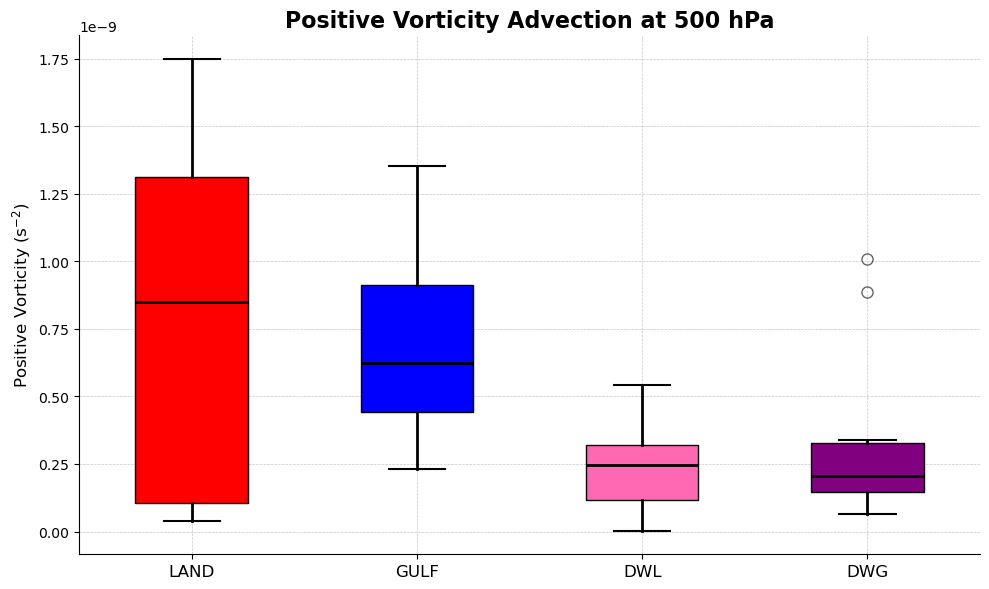

In [94]:
## Perfect. Box plot time!
## WE need to combine everything into a list
gvort_avg[gvort_avg < 0] = np.nan
lvort_avg[lvort_avg < 0] = np.nan
dwl_vort_avg[dwl_vort_avg < 0] = np.nan
dwg_vort_avg[dwg_vort_avg < 0] = np.nan
print(gvort_avg)
filtered_g = gvort_avg[~np.isnan(gvort_avg)]
filtered_l = lvort_avg[~np.isnan(lvort_avg)]
filtered_dwl = dwl_vort_avg[~np.isnan(dwl_vort_avg)]
filtered_dwg = dwg_vort_avg[~np.isnan(dwg_vort_avg)]


vorticity = [filtered_l, filtered_g, filtered_dwl, filtered_dwg]

#percentiles_l = np.percentile(lvort_avg, [10, 25, 50, 75, 90])
#print(percentiles_l)
#print()
#percentiles_g = np.percentile(gvort_avg, [10, 25, 50, 75, 90])
#print(percentiles_g)
#print()
#percentiles_dwl = np.percentile(dwl_vort_avg, [10, 25, 50, 75, 90])
#print(percentiles_dwl)
#print()
##print(percentiles_dwg)
#print()

colors = ['red', 'blue', 'hotpink', 'purple']

fig, ax = plt.subplots(figsize=(10,6))

box = ax.boxplot(vorticity, patch_artist = True, notch = False, widths = 0.5, 
                 medianprops = dict(color = 'black', linewidth = 2),
                 whiskerprops = dict(color = 'black', linewidth = 2),
                 capprops = dict(color='black', linewidth = 1.5),
                 flierprops = dict(marker = 'o', color = 'red', markersize = 8, alpha = 0.6))

## Add our colors
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

## Customize our axis
#ax.set_title("Relative Vorticity at 500 hPa", fontsize = 16, fontweight = 'bold')
ax.set_title("Positive Vorticity Advection at 500 hPa", fontsize = 16, fontweight = 'bold')
ax.set_ylabel('Positive Vorticity (s$^{-2}$)', fontsize = 12)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['LAND', 'GULF', 'DWL', 'DWG'], fontsize = 12)
ax.grid(True, which = 'major', linestyle = '--', linewidth = 0.5, alpha = 0.7)

## Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

plt.savefig('vort_adv_boxplots.png', dpi=300)

In [9]:
## Now to repeat the process for omega...yay
## GULF
wg_avg = gulf.mean(dim=['x','y'])['w'].values

## LAND
wl_avg = land.mean(dim=['x','y'])['w'].values

## DWL
w_dwl_avg = dwl.mean(dim=['x','y'])['w'].values

## DWG
w_dwg_avg = dwg.mean(dim=['x','y'])['w'].values

[-0.081957   -0.06420419  0.0202187   0.13544445  0.14661683]

[-0.08513556 -0.07427425  0.0124969   0.13583303  0.19382443]

[-0.10820348 -0.08419095 -0.01071477  0.06637167  0.13329188]

[-0.05524491 -0.04123534 -0.01375017  0.07127866  0.10574829]



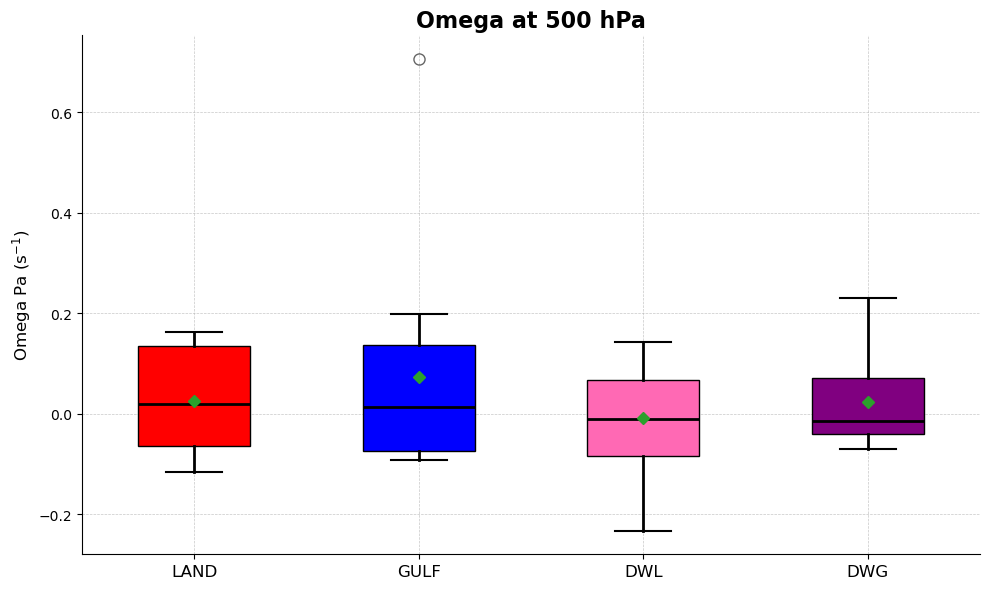

In [10]:
## Perfect. Box plot time!
## WE need to combine everything into a list

omega = [wl_avg, wg_avg, w_dwl_avg, w_dwg_avg]

percentiles_l = np.percentile(wl_avg, [10, 25, 50, 75, 90])
print(percentiles_l)
print()
percentiles_g = np.percentile(wg_avg, [10, 25, 50, 75, 90])
print(percentiles_g)
print()
percentiles_dwl = np.percentile(w_dwl_avg, [10, 25, 50, 75, 90])
print(percentiles_dwl)
print()
percentiles_dwg = np.percentile(w_dwg_avg, [10, 25, 50, 75, 90])
print(percentiles_dwg)
print()

colors = ['red', 'blue', 'hotpink', 'purple']

fig, ax = plt.subplots(figsize=(10,6))

box = ax.boxplot(omega, patch_artist = True, notch = False, widths = 0.5, 
                 medianprops = dict(color = 'black', linewidth = 2),
                 whiskerprops = dict(color = 'black', linewidth = 2),
                 capprops = dict(color='black', linewidth = 1.5),
                 flierprops = dict(marker = 'o', color = 'red', markersize = 8, alpha = 0.6),
                 showmeans=True,  # Add this to display the mean
                 meanprops=dict(marker='D', color='blue', markersize=6))

## Add our colors
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

## Customize our axis
ax.set_title("Omega at 500 hPa", fontsize = 16, fontweight = 'bold')
ax.set_ylabel('Omega Pa (s$^{-1}$)', fontsize = 12)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['LAND', 'GULF', 'DWL', 'DWG'], fontsize = 12)
ax.grid(True, which = 'major', linestyle = '--', linewidth = 0.5, alpha = 0.7)

## Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

plt.savefig('omega_boxplots', dpi=300)

In [11]:
## Now we get to repeat this same process for the winds at 250 hPa 
## But it's okay. Deep breaths

## GULF
p = 'rap_130*.grb2'

## WE want to open our data. This is for the 850 geopotential height level
datag = xr.open_mfdataset(p, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 250.0}},
                         combine = 'nested', concat_dim = 'valid_time')

## LAND
p2 = 'rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
datal = xr.open_mfdataset(p2, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 250.0}},
                         combine = 'nested', concat_dim = 'valid_time')

## DWL
p4 = 'rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
data_dwl = xr.open_mfdataset(p4, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 250.0}},
                         combine = 'nested', concat_dim = 'valid_time')

## DWG
p5 = 'rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
data_dwg = xr.open_mfdataset(p5, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 250.0}},
                         combine = 'nested', concat_dim = 'valid_time')

Ignoring index file 'rap_130_20170602_0600_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file 'rap_130_20170606_0600_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file 'rap_130_20170624_0700_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file 'rap_130_20170630_1300_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file 'rap_130_20180608_0900_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file 'rap_130_20180610_0800_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file 'rap_130_20180616_1200_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file 'rap_130_20180628_0700_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file 'rap_130_20190616_0600_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file 'rap_130_20200602_0700_000.grb2.9c67f.idx' incompatible with GRIB file
Ignoring index file 'rap_130_20200615_0500_000.grb2.9c67f.idx' incompatible with GRIB file

In [12]:
## We need to get our proper slices for this for each regime
## Gulf
datag.sel(x=slice(100,200), y=slice(100,200))
gulf = datag.sel(x=slice(235,262), y=slice(68,90))

##Left x is correct, others need to be adjusted 

## Land
datal.sel(x=slice(100,200), y=slice(100,200))
land = datal.sel(x=slice(235,262), y=slice(68,90))

## DWL
data_dwl.sel(x=slice(100,200), y=slice(100,200))
dwl = data_dwl.sel(x=slice(235,262), y=slice(68,90))

## DWG
data_dwg.sel(x=slice(100,200), y=slice(100,200))
dwg = data_dwg.sel(x=slice(235,262), y=slice(68,90))

dwg

<xarray.Dataset> Size: 224kB
Dimensions:        (valid_time: 15, y: 22, x: 27)
Coordinates:
    time           (valid_time) datetime64[ns] 120B 2017-06-11T09:00:00 ... 2...
    step           timedelta64[ns] 8B 00:00:00
    isobaricInhPa  float64 8B 250.0
    latitude       (y, x) float64 5kB dask.array<chunksize=(22, 27), meta=np.ndarray>
    longitude      (y, x) float64 5kB dask.array<chunksize=(22, 27), meta=np.ndarray>
  * valid_time     (valid_time) datetime64[ns] 120B 2017-06-11T09:00:00 ... 2...
Dimensions without coordinates: y, x
Data variables:
    gh             (valid_time, y, x) float32 36kB dask.array<chunksize=(1, 22, 27), meta=np.ndarray>
    t              (valid_time, y, x) float32 36kB dask.array<chunksize=(1, 22, 27), meta=np.ndarray>
    r              (valid_time, y, x) float32 36kB dask.array<chunksize=(1, 22, 27), meta=np.ndarray>
    w              (valid_time, y, x) float32 36kB dask.array<chunksize=(1, 22, 27), meta=np.ndarray>
    u              (valid_time, y, x) float32 36kB dask.array<chunksize=(1, 22, 27), meta=np.ndarray>
    v              (valid_time, y, x) float32 36kB dask.array<chunksize=(1, 22, 27), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-11-25T10:17 GRIB to CDM+CF via cfgrib-0.9.1...

In [13]:
## GULF
ug = gulf.u.metpy.quantify().metpy.convert_units('knot')
vg = gulf.v.metpy.quantify().metpy.convert_units('knot')
speedg = mpcalc.wind_speed(ug, vg).data.magnitude
print(speedg)
lonsg, latsg = gulf.longitude.values, gulf.latitude.values
dxg, dyg = mpcalc.lat_lon_grid_deltas(lonsg, latsg)
divg = mpcalc.divergence(ug, vg, dx=dxg[np.newaxis,:,:], dy=dyg[np.newaxis,:,:]).metpy.convert_units('1/s').data.magnitude
gulf['div'] = (gulf.gh.dims, divg)
gdiv_avg = gulf.mean(dim=['x','y'])['div'].values
gulf['speed'] = (gulf.gh.dims, speedg)
gspeed_avg = gulf.mean(dim=['x','y'])['speed'].values
uga = ug.metpy.unit_array.m
vga = vg.metpy.unit_array.m
winddir_g_rad = np.arctan2(uga, vga)
winddir_g = np.degrees(winddir_g_rad) +180
gulf['direc'] = (gulf.gh.dims, winddir_g)
g_dir_avg = gulf.mean(dim=['x','y'])['direc'].values


## LAND
ul = land.u.metpy.quantify().metpy.convert_units('knot')
vl = land.v.metpy.quantify().metpy.convert_units('knot')
speedl = mpcalc.wind_speed(ul, vl).data.magnitude
lonsl, latsl = land.longitude.values, land.latitude.values
dxl, dyl = mpcalc.lat_lon_grid_deltas(lonsl, latsl)
divl = mpcalc.divergence(ul, vl, dx=dxl[np.newaxis,:,:], dy=dyl[np.newaxis,:,:]).metpy.convert_units('1/s').data.magnitude
land['div'] = (land.gh.dims, divl)
ldiv_avg = land.mean(dim=['x','y'])['div'].values
land['speed'] = (land.gh.dims, speedl)
lspeed_avg = land.mean(dim=['x','y'])['speed'].values
##print(lspeed_avg)
ula = ul.metpy.unit_array.m
vla = vl.metpy.unit_array.m
winddir_l_rad = np.arctan2(ula, vla)
winddir_l = np.degrees(winddir_l_rad) +180
land['direc'] = (land.gh.dims, winddir_l)
l_dir_avg = land.mean(dim=['x','y'])['direc'].values

## DWL
udwl = dwl.u.metpy.quantify().metpy.convert_units('knot')
vdwl = dwl.v.metpy.quantify().metpy.convert_units('knot')
speeddwl = mpcalc.wind_speed(udwl, vdwl).data.magnitude
lonsdwl, latsdwl = dwl.longitude.values, dwl.latitude.values
dxdwl, dydwl = mpcalc.lat_lon_grid_deltas(lonsdwl, latsdwl)
divdwl = mpcalc.divergence(udwl, vdwl, dx=dxdwl[np.newaxis,:,:], dy=dydwl[np.newaxis,:,:]).metpy.convert_units('1/s').data.magnitude
dwl['div'] = (dwl.gh.dims, divdwl)
dwldiv_avg = dwl.mean(dim=['x','y'])['div'].values
dwl['speed'] = (dwl.gh.dims, speeddwl)
dwlspeed_avg = dwl.mean(dim=['x','y'])['speed'].values
udwla = udwl.metpy.unit_array.m
vdwla = vdwl.metpy.unit_array.m
winddir_dwl_rad = np.arctan2(udwla, vdwla)
winddir_dwl = np.degrees(winddir_dwl_rad) +180
dwl['direc'] = (dwl.gh.dims, winddir_dwl)
dwl_dir_avg = dwl.mean(dim=['x','y'])['direc'].values

## DWG
udwg = dwg.u.metpy.quantify().metpy.convert_units('knot')
vdwg = dwg.v.metpy.quantify().metpy.convert_units('knot')
speeddwg = mpcalc.wind_speed(udwg, vdwg).data.magnitude
lonsdwg, latsdwg = dwg.longitude.values, dwg.latitude.values
dxdwg, dydwg = mpcalc.lat_lon_grid_deltas(lonsdwg, latsdwg)
divdwg = mpcalc.divergence(udwg, vdwg, dx=dxdwg[np.newaxis,:,:], dy=dydwg[np.newaxis,:,:]).metpy.convert_units('1/s').data.magnitude
dwg['div'] = (dwg.gh.dims, divdwg)
dwgdiv_avg = dwg.mean(dim=['x','y'])['div'].values
dwg['speed'] = (dwg.gh.dims, speeddwg)
dwgspeed_avg = dwg.mean(dim=['x','y'])['speed'].values
udwga = udwg.metpy.unit_array.m
vdwga = vdwg.metpy.unit_array.m
winddir_dwg_rad = np.arctan2(udwga, vdwga)
winddir_dwg = np.degrees(winddir_dwg_rad) +180
dwg['direc'] = (dwg.gh.dims, winddir_dwg)
dwg_dir_avg = dwg.mean(dim=['x','y'])['direc'].values

dask.array<hypot, shape=(12, 22, 27), dtype=float32, chunksize=(1, 22, 27), chunktype=numpy.ndarray>


[-9.00227827e-06 -1.98375887e-06  1.87995009e-06  7.86898084e-06
  1.01645676e-05]

[-9.13981648e-06 -5.59743459e-06 -3.69186571e-06  4.57583265e-06
  9.72788850e-06]

[-9.09068510e-06 -6.27336410e-06 -1.71048522e-06  5.17927477e-06
  1.16902594e-05]

[-1.19680701e-05 -5.36991800e-06  1.62668510e-06  5.64933643e-06
  1.05006240e-05]



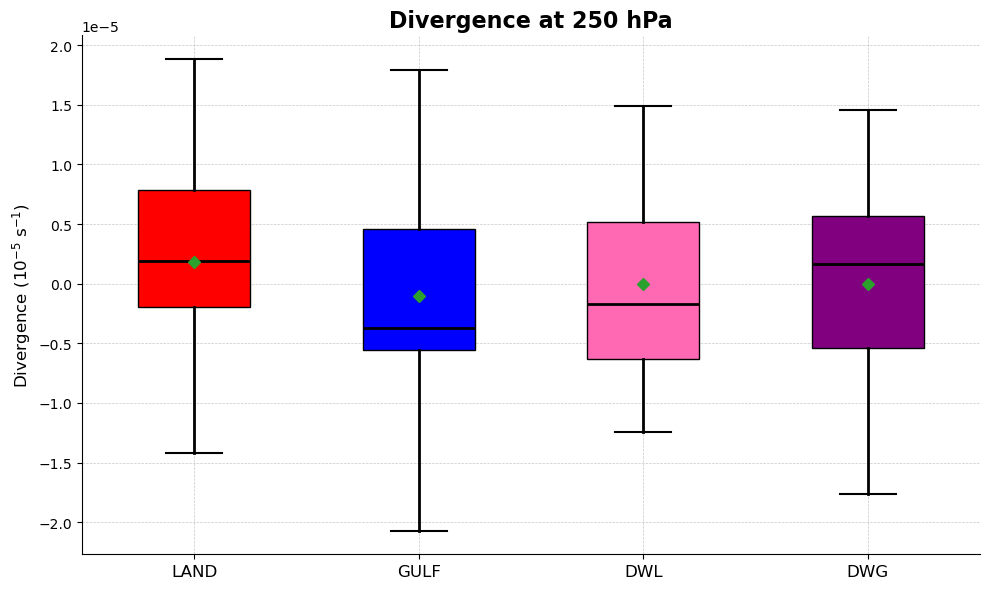

In [14]:
## Perfect. Box plot time!
## WE need to combine everything into a list

divergence = [ldiv_avg, gdiv_avg, dwldiv_avg, dwgdiv_avg]

percentiles_l = np.percentile(ldiv_avg, [10, 25, 50, 75, 90])
print(percentiles_l)
print()
percentiles_g = np.percentile(gdiv_avg, [10, 25, 50, 75, 90])
print(percentiles_g)
print()
percentiles_dwl = np.percentile(dwldiv_avg, [10, 25, 50, 75, 90])
print(percentiles_dwl)
print()
percentiles_dwg = np.percentile(dwgdiv_avg, [10, 25, 50, 75, 90])
print(percentiles_dwg)
print()


colors = ['red', 'blue', 'hotpink', 'purple']

fig, ax = plt.subplots(figsize=(10,6))

box = ax.boxplot(divergence, patch_artist = True, notch = False, widths = 0.5, 
                 medianprops = dict(color = 'black', linewidth = 2),
                 whiskerprops = dict(color = 'black', linewidth = 2),
                 capprops = dict(color='black', linewidth = 1.5),
                 flierprops = dict(marker = 'o', color = 'red', markersize = 8, alpha = 0.6),
                 showmeans=True,  # Add this to display the mean
                 meanprops=dict(marker='D', color='blue', markersize=6))

## Add our colors
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

## Customize our axis
ax.set_title("Divergence at 250 hPa", fontsize = 16, fontweight = 'bold')
ax.set_ylabel('Divergence ($10^{-5}$ s$^{-1}$)', fontsize = 12)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['LAND', 'GULF', 'DWL', 'DWG'], fontsize = 12)
ax.grid(True, which = 'major', linestyle = '--', linewidth = 0.5, alpha = 0.7)

## Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

plt.savefig('divergence_boxplots', dpi=300)

[14.58843508 22.34996891 28.40458965 34.05558586 46.5349823 ]

[10.52088203 11.58525467 23.65044022 34.69431114 39.28341026]

[ 9.84717846 12.7266922  18.8746376  26.88789749 34.53097458]

[13.13542023 17.81987286 20.44466972 31.38616276 41.03100586]



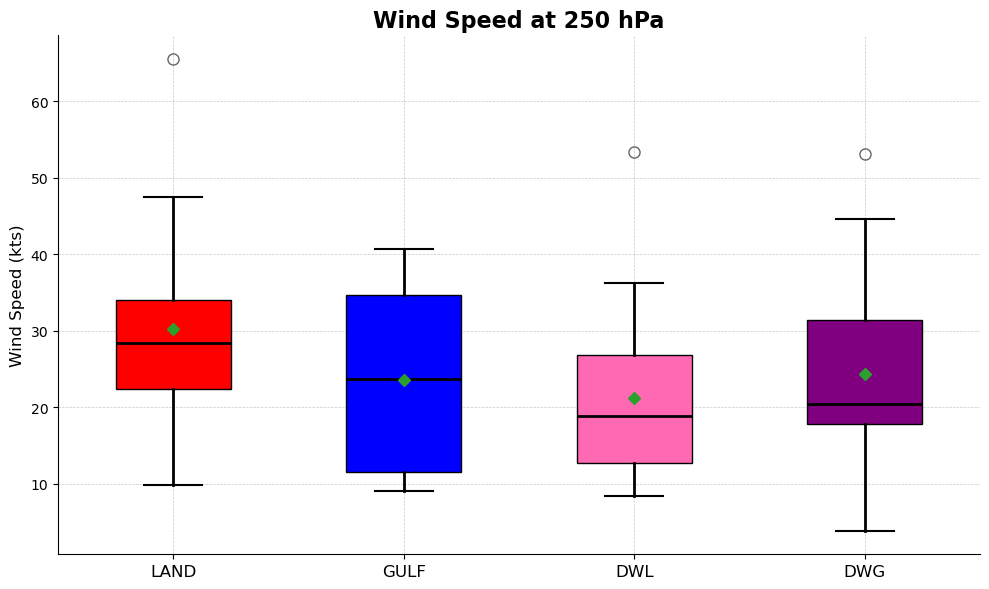

In [15]:
## Last one for now!

## Perfect. Box plot time!
## WE need to combine everything into a list

windspeed = [lspeed_avg, gspeed_avg, dwlspeed_avg, dwgspeed_avg]

percentiles_l = np.percentile(lspeed_avg, [10, 25, 50, 75, 90])
print(percentiles_l)
print()
percentiles_g = np.percentile(gspeed_avg, [10, 25, 50, 75, 90])
print(percentiles_g)
print()
percentiles_dwl = np.percentile(dwlspeed_avg, [10, 25, 50, 75, 90])
print(percentiles_dwl)
print()
percentiles_dwg = np.percentile(dwgspeed_avg, [10, 25, 50, 75, 90])
print(percentiles_dwg)
print()

colors = ['red', 'blue', 'hotpink', 'purple']

fig, ax = plt.subplots(figsize=(10,6))

box = ax.boxplot(windspeed, patch_artist = True, notch = False, widths = 0.5, 
                 medianprops = dict(color = 'black', linewidth = 2),
                 whiskerprops = dict(color = 'black', linewidth = 2),
                 capprops = dict(color='black', linewidth = 1.5),
                 flierprops = dict(marker = 'o', color = 'red', markersize = 8, alpha = 0.6),
                 showmeans=True,  # Add this to display the mean
                 meanprops=dict(marker='D', color='blue', markersize=6))

## Add our colors
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

## Customize our axis
ax.set_title("Wind Speed at 250 hPa", fontsize = 16, fontweight = 'bold')
ax.set_ylabel('Wind Speed (kts)', fontsize = 12)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['LAND', 'GULF', 'DWL', 'DWG'], fontsize = 12)
ax.grid(True, which = 'major', linestyle = '--', linewidth = 0.5, alpha = 0.7)

## Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

plt.savefig('windspeed_250_boxplots', dpi=300)

[152.1675354  256.01867676 269.82658386 294.74393463 331.65367889]

[ 84.44861145 184.7391777  256.79736328 306.51790619 324.40949402]

[120.00202942 174.99185181 236.51966858 261.90481567 309.87904663]

[ 87.17166138 106.79592133 204.56835938 278.71101379 296.66998596]



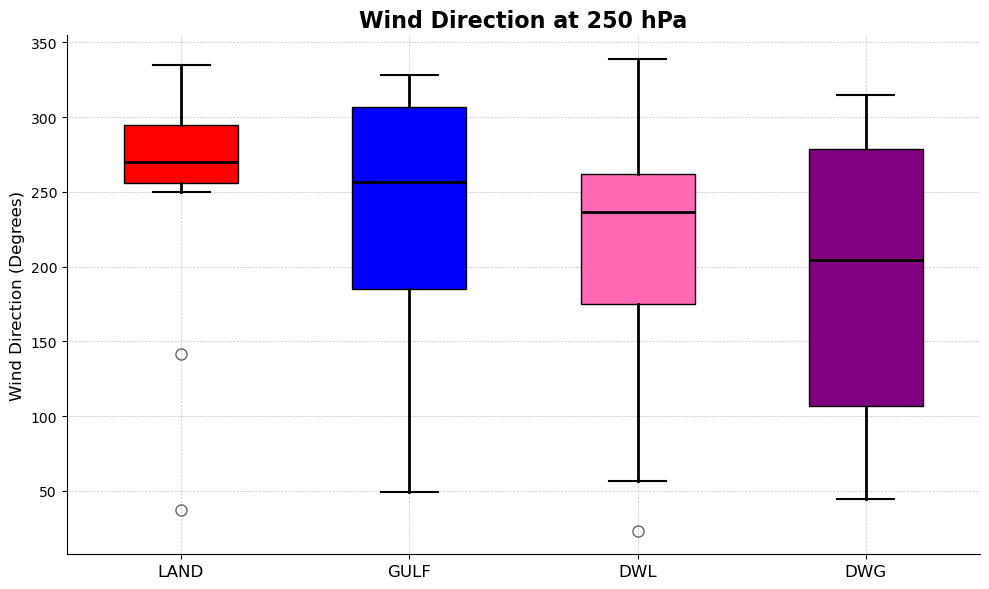

In [16]:
winddir = [l_dir_avg, g_dir_avg, dwl_dir_avg, dwg_dir_avg]
percentiles_l = np.percentile(l_dir_avg, [10, 25, 50, 75, 95])
print(percentiles_l)
print()
percentiles_g = np.percentile(g_dir_avg, [10, 25, 50, 75, 95])
print(percentiles_g)
print()
percentiles_dwl = np.percentile(dwl_dir_avg, [10, 25, 50, 75, 95])
print(percentiles_dwl)
print()
percentiles_dwg = np.percentile(dwg_dir_avg, [10, 25, 50, 75, 95])
print(percentiles_dwg)
print()

percentiles = [(np.percentile(data, 10), np.percentile(data, 90)) for data in winddir]
colors = ['red', 'blue', 'hotpink', 'purple']

fig, ax = plt.subplots(figsize=(10,6))

box = ax.boxplot(winddir, patch_artist = True, notch = False, widths = 0.5, 
                 medianprops = dict(color = 'black', linewidth = 2),
                 whiskerprops = dict(color = 'black', linewidth = 2),
                 capprops = dict(color='black', linewidth = 1.5),
                 flierprops = dict(marker = 'o', color = 'red', markersize = 8, alpha = 0.6))

##for i, (whisker, (p10, p90)) in enumerate(zip(box['whiskers'], percentiles)):
    # Each whisker consists of two Line2D objects (lower and upper whisker)
    ##whisker.set_data([1, 1], [p10, p90])

## Add our colors
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

## Customize our axis
ax.set_title("Wind Direction at 250 hPa", fontsize = 16, fontweight = 'bold')
ax.set_ylabel('Wind Direction (Degrees)', fontsize = 12)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['LAND', 'GULF', 'DWL', 'DWG'], fontsize = 12)
ax.grid(True, which = 'major', linestyle = '--', linewidth = 0.5, alpha = 0.7)

## Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

plt.savefig('winddir_250_boxplots', dpi=300)

In [17]:
## GULF
ug = gulf.u.metpy.quantify().metpy.convert_units('knot')
vg = gulf.v.metpy.quantify().metpy.convert_units('knot')
speedg = mpcalc.wind_speed(ug, vg).data.magnitude
print(speedg)
lonsg, latsg = gulf.longitude.values, gulf.latitude.values
dxg, dyg = mpcalc.lat_lon_grid_deltas(lonsg, latsg)
divg = mpcalc.divergence(ug, vg, dx=dxg[np.newaxis,:,:], dy=dyg[np.newaxis,:,:]).metpy.convert_units('1/s').data.magnitude
gulf['div'] = (gulf.gh.dims, divg)
gdiv_avg = gulf.mean(dim=['x','y'])['div'].values
gulf['speed'] = (gulf.gh.dims, speedg)
gspeed_avg = gulf.mean(dim=['x','y'])['speed'].values
uga = ug.metpy.unit_array.m
vga = vg.metpy.unit_array.m
winddir_g_rad = np.arctan2(uga, vga)
winddir_g = np.degrees(winddir_g_rad) +180
gulf['direc'] = (gulf.gh.dims, winddir_g)
g_dir_avg = gulf.mean(dim=['x','y'])['direc'].values


## LAND
ul = land.u.metpy.quantify().metpy.convert_units('knot')
vl = land.v.metpy.quantify().metpy.convert_units('knot')
speedl = mpcalc.wind_speed(ul, vl).data.magnitude
lonsl, latsl = land.longitude.values, land.latitude.values
dxl, dyl = mpcalc.lat_lon_grid_deltas(lonsl, latsl)
divl = mpcalc.divergence(ul, vl, dx=dxl[np.newaxis,:,:], dy=dyl[np.newaxis,:,:]).metpy.convert_units('1/s').data.magnitude
land['div'] = (land.gh.dims, divl)
ldiv_avg = land.mean(dim=['x','y'])['div'].values
land['speed'] = (land.gh.dims, speedl)
lspeed_avg = land.mean(dim=['x','y'])['speed'].values
##print(lspeed_avg)
ula = ul.metpy.unit_array.m
vla = vl.metpy.unit_array.m
winddir_l_rad = np.arctan2(ula, vla)
winddir_l = np.degrees(winddir_l_rad) +180
land['direc'] = (land.gh.dims, winddir_l)
l_dir_avg = land.mean(dim=['x','y'])['direc'].values

## DWL
udwl = dwl.u.metpy.quantify().metpy.convert_units('knot')
vdwl = dwl.v.metpy.quantify().metpy.convert_units('knot')
speeddwl = mpcalc.wind_speed(udwl, vdwl).data.magnitude
lonsdwl, latsdwl = dwl.longitude.values, dwl.latitude.values
dxdwl, dydwl = mpcalc.lat_lon_grid_deltas(lonsdwl, latsdwl)
divdwl = mpcalc.divergence(udwl, vdwl, dx=dxdwl[np.newaxis,:,:], dy=dydwl[np.newaxis,:,:]).metpy.convert_units('1/s').data.magnitude
dwl['div'] = (dwl.gh.dims, divdwl)
dwldiv_avg = dwl.mean(dim=['x','y'])['div'].values
dwl['speed'] = (dwl.gh.dims, speeddwl)
dwlspeed_avg = dwl.mean(dim=['x','y'])['speed'].values
udwla = udwl.metpy.unit_array.m
vdwla = vdwl.metpy.unit_array.m
winddir_dwl_rad = np.arctan2(udwla, vdwla)
winddir_dwl = np.degrees(winddir_dwl_rad) +180
dwl['direc'] = (dwl.gh.dims, winddir_dwl)
dwl_dir_avg = dwl.mean(dim=['x','y'])['direc'].values

## DWG
udwg = dwg.u.metpy.quantify().metpy.convert_units('knot')
vdwg = dwg.v.metpy.quantify().metpy.convert_units('knot')
speeddwg = mpcalc.wind_speed(udwg, vdwg).data.magnitude
lonsdwg, latsdwg = dwg.longitude.values, dwg.latitude.values
dxdwg, dydwg = mpcalc.lat_lon_grid_deltas(lonsdwg, latsdwg)
divdwg = mpcalc.divergence(udwg, vdwg, dx=dxdwg[np.newaxis,:,:], dy=dydwg[np.newaxis,:,:]).metpy.convert_units('1/s').data.magnitude
dwg['div'] = (dwg.gh.dims, divdwg)
dwgdiv_avg = dwg.mean(dim=['x','y'])['div'].values
dwg['speed'] = (dwg.gh.dims, speeddwg)
dwgspeed_avg = dwg.mean(dim=['x','y'])['speed'].values
udwga = udwg.metpy.unit_array.m
vdwga = vdwg.metpy.unit_array.m
winddir_dwg_rad = np.arctan2(udwga, vdwga)
winddir_dwg = np.degrees(winddir_dwg_rad) +180
dwg['direc'] = (dwg.gh.dims, winddir_dwg)
dwg_dir_avg = dwg.mean(dim=['x','y'])['direc'].values

dask.array<hypot, shape=(12, 22, 27), dtype=float32, chunksize=(1, 22, 27), chunktype=numpy.ndarray>


In [18]:
test = land.isel(valid_time = 2)

In [19]:
u_test = test.u.metpy.quantify().metpy.convert_units('knot')
v_test = test.v.metpy.quantify().metpy.convert_units('knot')
speed_test = mpcalc.wind_speed(u_test, v_test).data.magnitude

<xarray.DataArray 'hypot-79ae6a6bf3b1be88dd9a48f84aa82b9f' (y: 22, x: 27)> Size: 2kB
<Quantity(dask.array<hypot, shape=(22, 27), dtype=float32, chunksize=(22, 27), chunktype=numpy.ndarray>, 'knot')>
Coordinates:
    time           datetime64[ns] 8B 2018-06-11T18:00:00
    step           timedelta64[ns] 8B 00:00:00
    isobaricInhPa  float64 8B 250.0
    latitude       (y, x) float64 5kB dask.array<chunksize=(22, 27), meta=np.ndarray>
    longitude      (y, x) float64 5kB dask.array<chunksize=(22, 27), meta=np.ndarray>
    valid_time     datetime64[ns] 8B 2018-06-11T18:00:00
Dimensions without coordinates: y, x


Text(0.5, 1.0, '(A) LAND Regime 250-hPa Map')

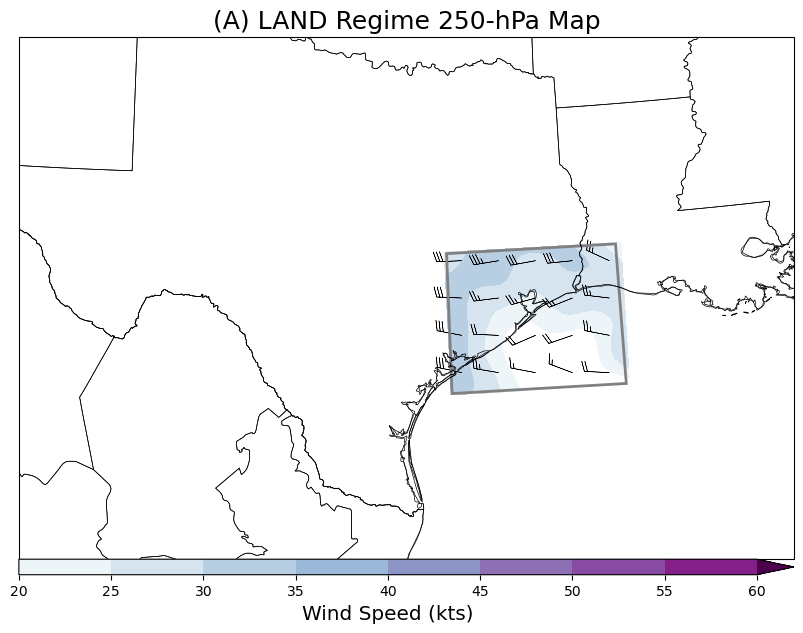

In [20]:
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = crs)
ax.set_extent([-105., -90., 25., 34.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())


lons, lats = test.longitude.values, test.latitude.values

## Get the heights and smooth so that it's not wobbly
##gh = (dsl.gh.values)/10. ## want it in decometers; 9 is smoothing value (typically between 6 and 12)
##cs = ax.contour(lons, lats, gh, levels = np.arange(1000, 1200, 6), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
##plt.clabel(cs)

## Show divergence
## Show divergence
##div = mpcalc.divergence(u, v, dx=dx, dy=dy).metpy.convert_units('1/s').data.magnitude
    
##divshade = ax.contourf(lons, lats, div * 1e5, cmap=plt.cm.bwr, levels = np.arange(-5,8,1), vmin = -15, vmax = 15, transform = ccrs.PlateCarree())
##cb2 = fig.colorbar(divshade, ax=ax, orientation = 'horizontal', pad = 0, aspect = 50, extend = "both")
## Create the colorbar for relative vorticity
##cb2.set_label('Divergence ($10^{-5}$ s$^{-1}$)', size='x-large')
speed = mpcalc.wind_speed(u_test, v_test)
print(speed)
wind = np.arange(20, 250, 20)
windjet = ax.contourf(lons, lats, speed, wind, cmap=plt.cm.BuPu, levels = np.arange(20,65, 5), vmin = 20, vmax = 65,
                  transform = ccrs.PlateCarree(), extend = "max")
## Create the colorbar for relative vorticity
cb2=fig.colorbar(windjet, ax=ax, orientation='horizontal', pad=0, aspect=50, extend = "max")
cb2.set_label('Wind Speed (kts)', size='x-large')

## u and v windbarbs
ax.barbs(lons, lats, u_test.data.magnitude, v_test.data.magnitude, regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())

ax.add_patch(rect)

ax.set_title('(A) LAND Regime 250-hPa Map',fontsize = 18)

In [21]:
u = land.mean(dim=['x','y'], keep_attrs=True).u
v = land.mean(dim=['x','y'], keep_attrs=True).v

wind_speed = mpcalc.wind_speed(u, v)

wind_speed.metpy.convert_units('kt').values.mean()

28.599813

In [22]:
## for box plots

## 1- Calculate wind speed using the land dataset 
## 2- then take the mean over those dimensions

In [23]:
p = 'rap_130*.grb2'

## WE want to open our data. This is for the 500 geopotential height level
datag = xr.open_mfdataset(p, engine='cfgrib', backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level': 500.0}},
                         combine = 'nested', concat_dim = 'valid_time')



datag.sel(x=slice(100,200), y=slice(100,200))
gulf = datag.sel(x=slice(235,262), y=slice(68,90))

test = gulf.isel(valid_time = 11)

u = test.u.metpy.quantify().metpy.convert_units('knot')
v = test.v.metpy.quantify().metpy.convert_units('knot')
w = test.w.metpy.quantify()

gulf

<xarray.Dataset> Size: 209kB
Dimensions:        (valid_time: 12, y: 22, x: 27)
Coordinates:
    time           (valid_time) datetime64[ns] 96B 2017-06-10T15:00:00 ... 20...
    step           timedelta64[ns] 8B 00:00:00
    isobaricInhPa  float64 8B 500.0
    latitude       (y, x) float64 5kB dask.array<chunksize=(22, 27), meta=np.ndarray>
    longitude      (y, x) float64 5kB dask.array<chunksize=(22, 27), meta=np.ndarray>
  * valid_time     (valid_time) datetime64[ns] 96B 2017-06-10T15:00:00 ... 20...
Dimensions without coordinates: y, x
Data variables:
    gh             (valid_time, y, x) float32 29kB dask.array<chunksize=(1, 22, 27), meta=np.ndarray>
    t              (valid_time, y, x) float32 29kB dask.array<chunksize=(1, 22, 27), meta=np.ndarray>
    r              (valid_time, y, x) float32 29kB dask.array<chunksize=(1, 22, 27), meta=np.ndarray>
    w              (valid_time, y, x) float32 29kB dask.array<chunksize=(1, 22, 27), meta=np.ndarray>
    u              (valid_time, y, x) float32 29kB dask.array<chunksize=(1, 22, 27), meta=np.ndarray>
    v              (valid_time, y, x) float32 29kB dask.array<chunksize=(1, 22, 27), meta=np.ndarray>
    absv           (valid_time, y, x) float32 29kB dask.array<chunksize=(1, 22, 27), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-11-08T14:39 GRIB to CDM+CF via cfgrib-0.9.1...

/var/folders/pc/3868n6_s5wggqvvzx3s5l2p80000gq/T/ipykernel_58801/4239508008.py:26: UserWarning: More than one time coordinate present for variable  "u".
  vor_500 = mpcalc.vorticity(u, v, dx=dx, dy=dy).metpy.convert_units('1/s').data.magnitude


Text(0.5, 1.0, '(C) Test GULF One Time')

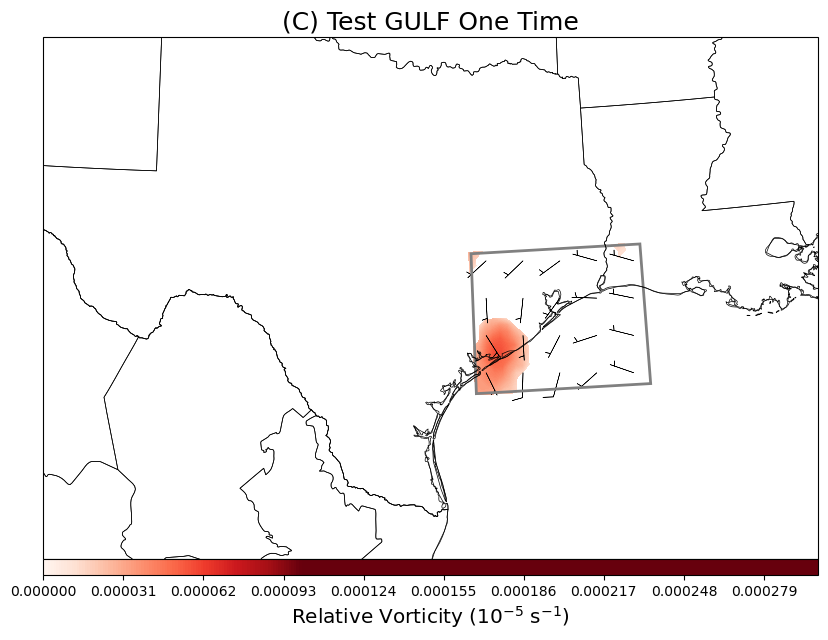

In [24]:
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
fig = plt.figure(figsize = (10,10))
##fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, projection = crs)
ax.set_extent([-105., -90., 25., 34.])
##ax.set_extent([-91., -108., 25., 36.])
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

small_extent = [-93, -96.5 ,28, 30.5]
lon_min, lon_max, lat_min, lat_max = small_extent
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min, linewidth = 2, edgecolor = 'grey', facecolor = 'none', transform = ccrs.PlateCarree())


lons, lats = gulf.longitude.values, gulf.latitude.values

## Get the heights and smooth so that it's not wobbly
##gh = (gulf.gh.values)/10.  ## want it in decometers; 9 is smoothing value (typically between 6 and 12)
##cs = ax.contour(lons, lats, gh, levels = np.arange(420, 660, 6), colors = 'k', transform = ccrs.PlateCarree())
## contour labels 
##plt.clabel(cs)

## Calculate and plot relative voriticyt 
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
vor_500 = mpcalc.vorticity(u, v, dx=dx, dy=dy).metpy.convert_units('1/s').data.magnitude
vor_500[vor_500 < 1e-5] = np.nan
cfv = ax.contourf(lons, lats, vor_500, cmap = 'Reds', levels = np.arange(0, 3.01e-4, 1e-6), vmin = 0, vmax = 1e-4,
                  transform = ccrs.PlateCarree())

## Create the colorbar for relative vorticity
cb2=fig.colorbar(cfv, ax=ax, orientation='horizontal', pad=0, aspect=50)
cb2.set_label(r'Relative Vorticity ($10^{-5}$ s$^{-1}$)', size='x-large')

## Calculate and plot vertical vorticity

##w = dsb1.w.metpy.quantify()
##cfr = ax.contourf(lons, lats, w.data.magnitude, cmap = 'RdBu', levels = np.arange(-1, 1, 0.01), vmin = -1, vmax = 1.1,
                 ## transform = ccrs.PlateCarree())

## Create the colorbar for relative vorticity
##cb2=fig.colorbar(cfr, ax=ax, orientation='horizontal', pad=0, aspect=50)
##cb2.set_label(r'Omega Pa/s', size='x-large')

## u and v windbarbs
ax.barbs(lons, lats, u.data.magnitude, v.data.magnitude, regrid_shape=15, length = 6, linewidth = 0.4,  
         sizes = {'emptybarb': 0}, transform = ccrs.PlateCarree())


ax.add_patch(rect)

ax.set_title('(C) Test GULF One Time',fontsize = 18)

In [ ]:
## Now we need to do box plots for positive vorticity advection
